## setup

In [174]:
import pandas as pd
import numpy as np
import cv2
import os
import os.path

import time

import requests
import json
import urllib
from bs4 import BeautifulSoup
import re
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import shutil


# show all dataframe
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_columns', None)  

## params

In [2]:
dir = 'clean image/mfaboston/'
err_page = []
err_object = []

# initiate a dataframe to store data
cols = ['object number', 'title','culture', 'medium', 'classifications']
df = pd.DataFrame(columns=cols)

headers={
'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'
}

In [32]:
# use the following code
# to quickly checkout one image

image_number = 8073
dir = 'clean image/mfaboston/'

def show_img(image_number,dir,df):

    img = df[df['object number']==image_number]
    object_title = img['title']
    print(object_title)

    filepath = dir + str(image_number) + '.jpg'
    img = Image.open(filepath)

    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

62    Fragment of a man's court robe (jifu)
Name: title, dtype: object


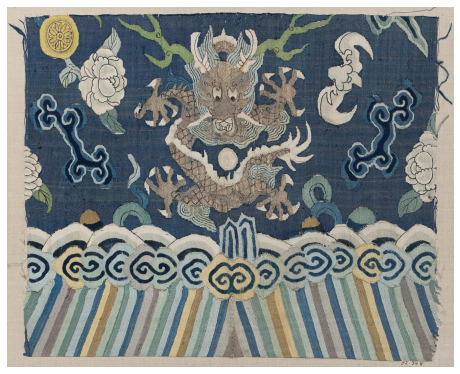

In [33]:
show_img(image_number,dir,df=df_7col)

## REQUEST 1: Get keyword : page number

In [65]:
keywords = ['robe', 'dress', 'shirt', 'coat', 'ensemble', 'suit', 'jacket','gown']

In [67]:
keyword_page_n_dict = {}

for keyword in keywords:
    url = f"https://collections.mfa.org/search/Objects/*/{keyword}/images?filter=allClassifications%3ACostumes%3BimageExistence%3Atrue"
    r = requests.get(url)
    soup_key = BeautifulSoup(r.content,'html.parser')
    page_n = soup_key.find('span', class_="maxPages").text[2:].strip()

    keyword_page_n_dict[keyword] = page_n
    print(f'there are {page_n} pages for keyword {keyword}.')

there are 35 pages for keyword robe.
there are 116 pages for keyword dress.
there are 19 pages for keyword shirt.
there are 27 pages for keyword coat.
there are 32 pages for keyword ensemble.
there are 19 pages for keyword suit.
there are 40 pages for keyword jacket.
there are 9 pages for keyword gown.


## REQUEST 2: read each 12 obj grid page

### def get_12_obj_df(soup)

In [113]:
def get_12_obj_df(soup):
    # each page has 12 images
    # read each image
    # capture the number and url
    k = soup.find_all('div',class_="primaryMedia")

    # init a df to store 12 obj data
    cols = ['object number', 'object url', 'download number', 'download url']
    df = pd.DataFrame(columns=cols)

    # there are chances to get timeout when read image page    
    for j in range(len(k)):
        # locate object number 
        object_str = k[j].find('a').get('href')
        object_number = re.search('objects/(.*?)/', object_str).group(1)
        url_base = 'https://collections.mfa.org'
        object_url = url_base + object_str 

        # locate download_number
        download_str = k[j].find('img').get('src')
        download_number = re.search('dispatcher/(.*?)/', download_str).group(1)
        download_url = f'https://collections.mfa.org/internal/media/dispatcher/{download_number}/resize%3Aformat%3Dfull?download'

        dc = [object_number,object_url,download_number,download_url]
        df_addon = pd.DataFrame(dc).T
        df_addon.columns = cols
        df = pd.concat([df,df_addon])
        
    return df

###  execute

In [118]:
keyword_page_n_dict

{'robe': '35',
 'dress': '116',
 'shirt': '19',
 'coat': '27',
 'ensemble': '32',
 'suit': '19',
 'jacket': '40',
 'gown': '9'}

In [119]:
# init a df to store obj number and url
cols = ['object number', 'object url', 'download number', 'download url']
df = pd.DataFrame(columns=cols)
timeout_dict = {}

# read each page
for keyword in keywords:
    # get the page number for this keyword
    page_n = keyword_page_n_dict[keyword]
    pages = range(1, int(page_n)+1)

    # loop times
    count = 0
    
    while bool(pages) is True:
        count += 1
        timeout_pages = []

        if count >= 11:
            timeout_dict[keyword] = pages
            break
        else:
            for i in pages:
                try:
                    url = f"https://collections.mfa.org/search/Objects/*/{keyword}/images?filter=allClassifications%3ACostumes%3BimageExistence%3Atrue&page={i}"
                    r = requests.get(url, headers = headers)
                    soup_page = BeautifulSoup(r.content,'html.parser')
                    thisdf = get_12_obj_df(soup_page)
                    df = pd.concat([df, thisdf])
                    
                except:
                    # print out err page
                    timeout_pages.append(i)
                    print(f'{keyword} - page {i} - timeout')
        # let the timeout pages be the pages for next round
        print(f'keyword: {keyword}, round {count}, timeout page count: {len(timeout_pages)}')
        pages = timeout_pages          

    print(f'keyword {keyword} is done.')     

robe - page 6 - timeout
robe - page 7 - timeout
robe - page 29 - timeout
robe - page 30 - timeout
keyword: robe, round 1, timeout page count: 4
keyword: robe, round 2, timeout page count: 0
keyword robe is done.
dress - page 3 - timeout
dress - page 12 - timeout
dress - page 13 - timeout
dress - page 35 - timeout
dress - page 36 - timeout
dress - page 37 - timeout
dress - page 42 - timeout
dress - page 58 - timeout
dress - page 59 - timeout
dress - page 81 - timeout
dress - page 82 - timeout
dress - page 83 - timeout
dress - page 84 - timeout
dress - page 106 - timeout
dress - page 107 - timeout
dress - page 108 - timeout
dress - page 109 - timeout
dress - page 110 - timeout
keyword: dress, round 1, timeout page count: 18
dress - page 3 - timeout
dress - page 37 - timeout
dress - page 42 - timeout
keyword: dress, round 2, timeout page count: 3
dress - page 3 - timeout
dress - page 37 - timeout
dress - page 42 - timeout
keyword: dress, round 3, timeout page count: 3
dress - page 3 - tim

In [122]:
df.shape

(3447, 4)

In [123]:
df.sample(3)

,object number,object url,download number,download url
0,530079,https://collections.mfa.org/objects/530079/womans-dress;jsessionid=9340C8CB42CF9396BAAADD526A54EAB6?ctx=1e90fa57-b6ad-43dc-8922-8e1e6bf27512&idx=1011,1352408,https://collections.mfa.org/internal/media/dispatcher/1352408/resize%3Aformat%3Dfull?download
0,567928,https://collections.mfa.org/objects/567928/skirt-suit;jsessionid=501C109F01374275F84EE52A8B4CCAFF?ctx=d0d82c0e-8d3f-43d4-bc4d-f03dd0a735c4&idx=138,1352441,https://collections.mfa.org/internal/media/dispatcher/1352441/resize%3Aformat%3Dfull?download
0,561054,https://collections.mfa.org/objects/561054/dress;jsessionid=6546A7AF001FEECCD640F1D79E88769B?ctx=24db38ec-85f7-4f3e-8a7b-2d4544b613e2&idx=1065,1248210,https://collections.mfa.org/internal/media/dispatcher/1248210/resize%3Aformat%3Dfull?download


In [132]:
# save the file in case
df.to_csv('raw data/mfaboston.csv', index=False)

# --> dataframe saved here, continue working from here

# REQUEST 3: read single obj page, save info

In [3]:
# read the file and prepare it for next step
df = pd.read_csv('raw data/mfaboston.csv')

# adding cols for store new info
cols = ['title', 'culture', 'object type', 'downloadable']
df[cols] = np.nan

In [4]:
# check if loaded correctly
df.shape

(3447, 8)

In [5]:
df.head(3)

,object number,object url,download number,download url,title,culture,object type,downloadable
0,24510,https://collections.mfa.org/objects/24510/noh-costume-atsuita;jsessionid=AF89E578CDE8EF15BA693C213C7E67AE?ctx=f523b82f-d3f8-49b2-b58b-ad4b83b11e67&idx=0,757433,https://collections.mfa.org/internal/media/dispatcher/757433/resize%3Aformat%3Dfull?download,NaN,NaN,NaN,NaN
1,645007,https://collections.mfa.org/objects/645007/bugaku-costume-in-5-parts-undercoat-shitagansane-vest-h;jsessionid=AF89E578CDE8EF15BA693C213C7E67AE?ctx=f523b82f-d3f8-49b2-b58b-ad4b83b11e67&idx=1,1493972,https://collections.mfa.org/internal/media/dispatcher/1493972/resize%3Aformat%3Dfull?download,NaN,NaN,NaN,NaN
2,155566,https://collections.mfa.org/objects/155566/kesa-buddhist-priests-robe;jsessionid=AF89E578CDE8EF15BA693C213C7E67AE?ctx=f523b82f-d3f8-49b2-b58b-ad4b83b11e67&idx=2,1007847,https://collections.mfa.org/internal/media/dispatcher/1007847/resize%3Aformat%3Dfull?download,NaN,NaN,NaN,NaN


## define function save dataframe

In [32]:
# save single object data to dataframe
def save_dataframe(row):
    """
    given obj url and download url
    requests and bs
    while downloadable nan, try except
    save data
    check if there is a download button
    if yes: save img + download label yes
    if no: download label no
    """
    obj_url = row['object url']
    obj_n = row['object number']

    newrow = row

    try:
        # get the bs for object page
        req = requests.get(obj_url, headers=headers)
        soup_obj = BeautifulSoup(req.content,'html.parser') 

        # get the block of item details
        tagobj = soup_obj.find('div',class_="item-details-inner")

        # locate the block that we need 
        tagleft = tagobj.contents[1] # which is the table on the left side of page
        
        # fill title, culture
        newrow['title'] = tagleft.contents[0].text # add title
        newrow['culture'] = soup_obj.find('div',class_="detailField cultureField")
        newrow['object type'] = soup_obj.find('div',class_="detailField cultureField")

        # check if the image is downloadable
        # by checking if there is a 'download' button
        # the image with 'download' button is believed to be in public domain
        bl = soup_obj.body.findAll(text='DOWNLOAD')

        if bool(bl) is True:
            newrow['downloadable'] = 'Y'
        else:
            newrow['downloadable'] = 'N'

    except:
        print(f'object {obj_n} got err')
        pass

    return newrow

In [45]:
df_7col = df.apply(lambda row: save_dataframe(row), axis=1)

object 120599 got err
object 120600 got err
object 121046 got err
object 121048 got err
object 8074 got err
object 19187 got err
object 19371 got err
object 19488 got err
object 20121 got err
object 20867 got err
object 67746 got err
object 68343 got err
object 68358 got err
object 68375 got err
object 24496 got err
object 15876 got err
object 15882 got err
object 16112 got err
object 106092 got err
object 642762 got err
object 642814 got err
object 646085 got err
object 675723 got err
object 695125 got err
object 536926 got err
object 80281 got err
object 80283 got err
object 46072 got err
object 46284 got err
object 46285 got err
object 46478 got err
object 94367 got err
object 94417 got err
object 94423 got err
object 95272 got err
object 95289 got err
object 401493 got err
object 353211 got err
object 353217 got err
object 353218 got err
object 551711 got err
object 551717 got err
object 551720 got err
object 551723 got err
object 551731 got err
object 555990 got err
object 555991 

In [ ]:
# run this code several times, until no nan in downloadable
df_7col.loc[df_7col['downloadable'].isna() == True] = df_7col.loc[df_7col['downloadable'].isna() == True].apply(lambda row: save_dataframe(row), axis=1)
print(df_7col['downloadable'].isna().sum())

In [73]:
df_7col.isna().sum()

object number        0
object url           0
download number      0
download url         0
title                0
culture            106
downloadable         0
dtype: int64

In [61]:
# save the file in case
# df_7col.to_csv('raw data/mfaboston_7col.csv', index=False)

# --> dataframe saved here, continue working from here

In [156]:
df_7col = pd.read_csv('raw data/mfaboston_7col.csv')

In [157]:
df_7col.head(3)

,object number,object url,download number,download url,title,culture,downloadable
0,24510,https://collections.mfa.org/objects/24510/noh-costume-atsuita;jsessionid=AF89E578CDE8EF15BA693C213C7E67AE?ctx=f523b82f-d3f8-49b2-b58b-ad4b83b11e67&idx=0,757433,https://collections.mfa.org/internal/media/dispatcher/757433/resize%3Aformat%3Dfull?download,Noh costume (atsuita)Kimono,"<div class=""detailField cultureField"">\nJapanese\n</div>",Y
1,645007,https://collections.mfa.org/objects/645007/bugaku-costume-in-5-parts-undercoat-shitagansane-vest-h;jsessionid=AF89E578CDE8EF15BA693C213C7E67AE?ctx=f523b82f-d3f8-49b2-b58b-ad4b83b11e67&idx=1,1493972,https://collections.mfa.org/internal/media/dispatcher/1493972/resize%3Aformat%3Dfull?download,Bugaku costume in 5 parts: undercoat (shitagansane); vest (hanpi); split skirt (hakama); helmet (torikabuto) and under robe,"<div class=""detailField cultureField"">\nJapanese\n</div>",Y
2,155566,https://collections.mfa.org/objects/155566/kesa-buddhist-priests-robe;jsessionid=AF89E578CDE8EF15BA693C213C7E67AE?ctx=f523b82f-d3f8-49b2-b58b-ad4b83b11e67&idx=2,1007847,https://collections.mfa.org/internal/media/dispatcher/1007847/resize%3Aformat%3Dfull?download,Kesa (Buddhist priest's robe),"<div class=""detailField cultureField"">\nJapanese\n</div>",Y


# REQUEST 4: download images

In [158]:
# create a dataframe with only downloadable costumes
df_y = df_7col.loc[df_7col['downloadable']=='Y']
df_y.shape

(1601, 7)

In [159]:
# create a col to identify if the image has been downloaded or not
df_y['downloaded'] = 'N'

C:\Users\yanha\AppData\Local\Temp\ipykernel_22952\359443976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y['downloaded'] = 'N'


In [160]:
df_y.loc[df_y['downloaded'] == 'N','downloaded'].shape[0]

1601

In [161]:
df_y.drop_duplicates(subset=['download number'],inplace=True)

C:\Users\yanha\AppData\Local\Temp\ipykernel_22952\1767030105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.drop_duplicates(subset=['download number'],inplace=True)


In [162]:
df_y.shape

(1379, 8)

In [194]:
df_y[df_y['title'].str.contains('clip')]

,object number,object url,download number,download url,title,culture,downloadable,downloaded
1493,513163,https://collections.mfa.org/objects/513163/lorgnette;jsessionid=9ED90FD77AE35687622A09790A0DD6E9?ctx=5f8d13fa-0bd3-4dfd-bbd1-a670b26133a5&idx=1235,1216589,https://collections.mfa.org/internal/media/dispatcher/1216589/resize%3Aformat%3Dfull?download,LorgnetteDress clip lorgnette,"<div class=""detailField cultureField"">\nAmerican\n</div>",Y,N


1493    LorgnetteDress clip lorgnette
Name: title, dtype: object


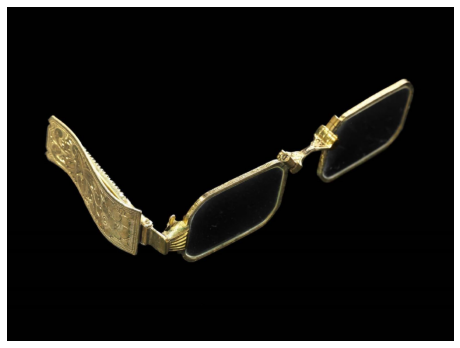

In [193]:
show_img(513163,dir,df=df_y)

In [34]:
def download_image(dir, row):
    """
    given a dataframe row of one object
    request and bs url
    save image
    label Y for col
    """
    newrow = row
    n = row['object number']
    filename = dir + str(n) + '.jpg'
    download_url = row['download url']

    try:
        z = urllib.request.urlopen(download_url)
        output = open(filename, 'wb')
        output.write(z.read())
        output.close()
        newrow['downloaded'] = 'Y'
        
    except:
        print(f'object {n} got error')

    return newrow

In [35]:
# loop to download all images
# max loop 20

# some init params
count = 0
n_num = df_y.loc[df_y['downloaded'] == 'N','downloaded'].shape[0]
dir = 'clean image/mfaboston/'

# start loop
while n_num != 0:
    if count >= 21:
        break
    else:
        count += 1
        print(f'this is round {count}')
        df_y = df_y.apply(lambda row: download_image(dir, row), axis=1)
        n_num = df_y.loc[df_y['downloaded'] == 'N','downloaded'].shape[0]
        print(f'{n_num} images not downloaded yet.')

this is round 1
object 538092 got error
object 581989 got error
object 583655 got error
object 488662 got error
object 502619 got error
object 603243 got error
object 556642 got error
object 106081 got error
object 37359 got error
object 556860 got error
10 images not downloaded yet.
this is round 2
object 65645 got error
object 20867 got error
object 23534 got error
object 24170 got error
object 24171 got error
object 24172 got error
object 24173 got error
object 28303 got error


# cleanup folder

In [195]:
# get a dataframe filtered out the following keywords
unwanted_list = ['Roundel','Fragment','fragments','Purse','Cuff','Length',
'collar','bag','Bonnet','slippers','stockings','holder','fan',
'Folding fan','Artificial flowers','sleeve puffs','Mitre','boots',
'box','Fan','Mask','Strap','shoes','Panel','Bows','necktie','clip']

In [196]:
for w in unwanted_list:
    df_y.loc[df_y['title'].str.contains(w),'title'] = np.nan
    df_y.dropna(subset=['title'],inplace=True)

C:\Users\yanha\AppData\Local\Temp\ipykernel_22952\26719326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.dropna(subset=['title'],inplace=True)
C:\Users\yanha\AppData\Local\Temp\ipykernel_22952\26719326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.dropna(subset=['title'],inplace=True)
C:\Users\yanha\AppData\Local\Temp\ipykernel_22952\26719326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.dropna(subset=[

In [197]:
df_y['title'].isna().sum()

0

In [198]:
df_y.shape

(1093, 8)

In [199]:
# save the file in case
df_y.to_csv('raw data/mfaboston_sel.csv', index=False)

## --> dataframe saved here, continue working from here

## copy selected to another folder

In [200]:
df_yy = pd.read_csv('raw data/mfaboston_sel.csv')
df_yy.shape

(1093, 8)

In [201]:
def copy_file(obj_number):
    src_path = 'clean image/mfaboston/'
    des_path = 'clean image/mfaboston_sel/'
    source = src_path + str(obj_number) +'.jpg'
    destination = des_path + str(obj_number) +'.jpg'
    
    try:
        shutil.copy(source, destination)

    except:
        pass

In [203]:
df_yy['object number'].apply(lambda x: copy_file(x))

0       None
1       None
2       None
3       None
4       None
        ... 
1088    None
1089    None
1090    None
1091    None
1092    None
Name: object number, Length: 1093, dtype: object